### LOADING LIBRARIES

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.backend as K
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import cv2, glob, os
import time
from pathlib import Path
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from generator import *
from utils import *

In [3]:
print(tf.__version__)

1.13.1


In [4]:
SEED = 100
np.random.seed(SEED)
tf.random.set_random_seed(SEED)

***Uncomment below cell to download data***

In [5]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat
# !wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz
##!sudo apt-get install tar
# !tar xvzf car_ims.tgz

### LOADING DATA

In [6]:
!python generate_csv.py

/media/danish/Data/anaconda/envs/tf/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
img_path = Path('./')

In [8]:
data = scipy.io.loadmat('./cars_annos.mat')
classes = {i:data['class_names'][0][i][0] for i in range(data['class_names'].shape[1])}

In [9]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [10]:
train_data.target -=1
test_data.target -=1

In [11]:
train_data.head()

,filename,target
0,car_ims/006510.jpg,79
1,car_ims/009098.jpg,110
2,car_ims/013462.jpg,163
3,car_ims/010743.jpg,129
4,car_ims/012100.jpg,146


In [13]:
name_label={v:k for k,v in classes.items()}

In [14]:
def to_ohe(label,num_classes=7):
    return np.array(k.utils.to_categorical(label,num_classes=num_classes))

(184, 274, 3)


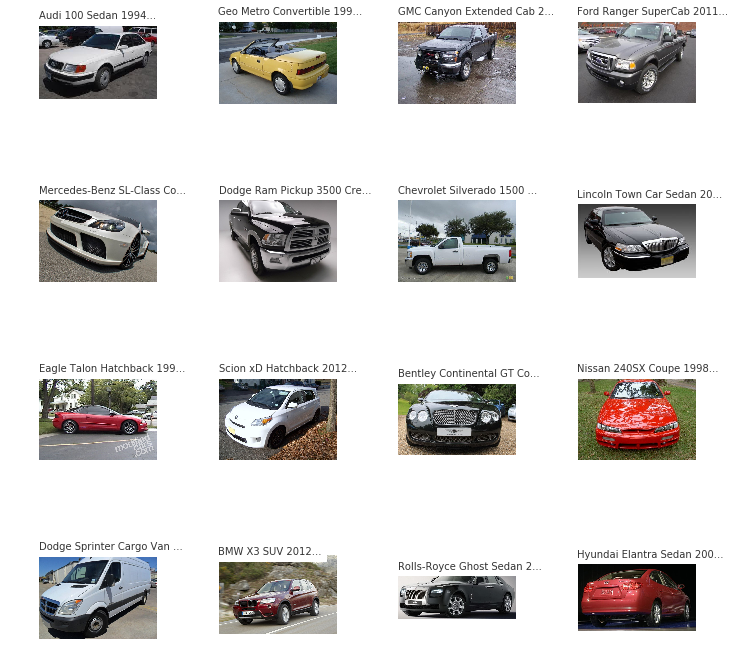

In [15]:
plot_batch_img(img_path,train_data,classes,batch=30)

In [16]:
## Splitting data into train and validation set
train_data,valid_data = train_test_split(train_data,test_size=0.20,random_state=SEED)
train_data.shape,valid_data.shape

((6432, 2), (1609, 2))

In [17]:
train_data.reset_index(drop=True,inplace=True)
valid_data.reset_index(drop=True,inplace=True)

### GENERATOR

In [18]:
from albumentations import (HorizontalFlip, IAAPerspective, ShiftScaleRotate,
                            CLAHE, RandomRotate90, Transpose, ShiftScaleRotate,
                            Blur, OpticalDistortion, GridDistortion,
                            HueSaturationValue, IAAAdditiveGaussianNoise,
                            GaussNoise, MotionBlur, MedianBlur,Rotate,
                            IAAPiecewiseAffine, IAASharpen, IAAEmboss,
                            RandomBrightnessContrast, Flip, OneOf, Compose)


def randomAugment(p=0.7):
    return Compose([
        HorizontalFlip(p=0.5),
        Rotate(limit=(-30,30), p=0.7),
        HueSaturationValue(p=0.2),
        GaussNoise(p=0.3),
        OneOf([
            MedianBlur(blur_limit=3, p=0.2),
            Blur(blur_limit=3, p=0.2),
        ], p=0.2),
        OneOf([
            IAASharpen(),
            RandomBrightnessContrast(),
        ], p=0.3),
    ], p=p)

In [20]:
def plot_imgs(im,dic,label,bt=0,rw=4,cl=4):
    fig, axes = plt.subplots(rw,cl, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        display_img(im[i],dic,label[i], ax=ax,ohe=True)
    plt.tight_layout(pad=0.01)

In [22]:
#Input size of the model
input_size=256

In [23]:
class DataGenerator(Sequence):
    '''Generate batch of images and target'''
    def __init__(self,df, bs,is_valid=False):
        '''Initialize the Generator class
        Parameters :
            df : DataFrame, containing names and target value of images
            bs : int , batch size
            is_valid : Bool, Flag for applying data augmentation 
        '''
        self.df = df
        self.bs = bs
        self.is_valid = is_valid 
        self.augmentation = randomAugment(p=0.7)
        
    def __len__(self) :
        '''Return the length of the data'''
        return np.ceil(self.df.shape[0] / self.bs).astype(int)

    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        if self.is_valid == False:
            self.df = shuffle(self.df, random_state=SEED)
            self.df.reset_index(inplace=True, drop=True)

    def set_bs(self,new_bs) :
        '''Change the batch size by by passing new batch size'''
        self.bs=new_bs
    
    def __getitem__(self, idx):
        '''Generate batch of images and target'''
        x_batch, y_batch = [], []
        start = idx * self.bs
        end = (idx + 1) * self.bs
        ids_train_batch = self.df.filename[start:end].values
        labels = self.df.target[start:end].values
        for i, ids in enumerate(ids_train_batch):
            img = load_img(str(img_path / ids))
            target = to_ohe(labels[i],196)
            ## Augmentation
            if self.is_valid == False:
                img = self.augmentation(image=(img).astype(np.uint8))['image']
            x_batch.append(img)
            y_batch.append(target)
        x_batch = np.array(x_batch, np.float32) / 255.
        y_batch = np.array(y_batch, np.float32)

        return x_batch, y_batch
        

In [24]:
bs = 16

In [25]:
train_generator = DataGenerator(train_data,bs,False)
valid_generator = DataGenerator(valid_data,bs,True)

In [26]:
l = valid_generator.__getitem__(3)
l[0].shape,l[1].shape

((16, 256, 256, 3), (16, 196))

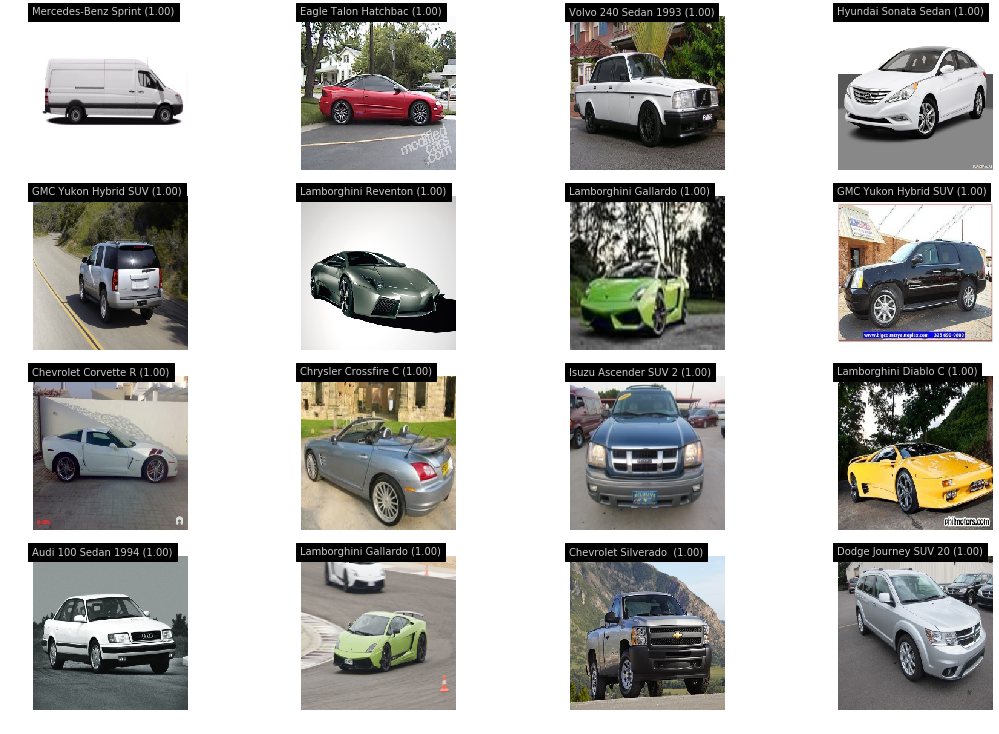

In [27]:
#Results from data generator
plot_imgs(l[0],classes,l[1])

### MODEL

In [28]:
input_size=256
numclass=196

In [29]:
def get_model():
    #Pretrained Xception network without head
    pretrained_model = k.applications.ResNet50(
        weights="imagenet",
        input_tensor=k.layers.Input(shape=(input_size, input_size, 3),
                                    name='feature'),
        include_top=False)
    #Freezing the body of the network
    for layer in pretrained_model.layers:
        layer.trainable = False
    #Head of the model
    x = pretrained_model.output
    x = k.layers.GlobalAveragePooling2D()(x)
    x = k.layers.Dense(256,name='head_dense')(x)
    x = k.layers.BatchNormalization()(x)
    x = k.layers.ReLU()(x)
    output = k.layers.Dense(numclass,
                            name='predictions',
                            activation='softmax')(x)
    model = k.Model(inputs=pretrained_model.input,
                    outputs=output,
                    name='Classification_Network')

    return model

In [30]:
model = get_model()
model.summary(110)

Instructions for updating:
Colocations handled automatically by placer.
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
feature (InputLayer)                (None, 256, 256, 3)     0                                                 
______________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)           (None, 262, 262, 3)     0            feature[0][0]                        
______________________________________________________________________________________________________________
conv1 (Conv2D)                      (None, 128, 128, 64)    9472         conv1_pad[0][0]                      
______________________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1)     (Non

### TRAINING

In [31]:
learning_rate=0.001
adam=k.optimizers.Adam(lr=learning_rate,decay=1e-3)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
def fit(epoch=2):
    model.fit_generator(
        generator=train_generator,
        steps_per_epoch=int(np.ceil(train_data.shape[0]) / (bs)),
        epochs=epoch,verbose=1,
        validation_data=valid_generator,
        workers=4,
        validation_steps=int(np.ceil(valid_data.shape[0]) / (bs)))

In [33]:
fit(2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
402/402 [==============================] - 62s 153ms/step - loss: 4.6278 - acc: 0.0880 - val_loss: 6.1920 - val_acc: 0.0025
Epoch 2/2
402/402 [==============================] - 60s 148ms/step - loss: 3.2496 - acc: 0.3085 - val_loss: 6.4623 - val_acc: 0.0025


In [34]:
for layer in model.layers:
    layer.trainable = True
lr=5e-4
adam=k.optimizers.Adam(lr=lr)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
fit(10)

Epoch 1/10
402/402 [==============================] - 264s 656ms/step - loss: 3.2323 - acc: 0.2388 - val_loss: 6.1726 - val_acc: 0.0031
Epoch 2/10
402/402 [==============================] - 360s 895ms/step - loss: 2.0638 - acc: 0.4960 - val_loss: 3.6745 - val_acc: 0.1722
Epoch 3/10
402/402 [==============================] - 360s 895ms/step - loss: 1.4426 - acc: 0.6493 - val_loss: 2.1344 - val_acc: 0.4605
Epoch 4/10
402/402 [==============================] - 375s 933ms/step - loss: 1.0589 - acc: 0.7410 - val_loss: 2.2395 - val_acc: 0.4438
Epoch 5/10
402/402 [==============================] - 375s 934ms/step - loss: 0.8147 - acc: 0.8004 - val_loss: 2.3328 - val_acc: 0.4307
Epoch 6/10
402/402 [==============================] - 394s 981ms/step - loss: 0.5907 - acc: 0.8531 - val_loss: 1.8355 - val_acc: 0.5295
Epoch 7/10
402/402 [==============================] - 369s 919ms/step - loss: 0.4986 - acc: 0.8748 - val_loss: 2.0321 - val_acc: 0.4755
Epoch 8/10
402/402 [============================

In [36]:
k.backend.set_value(adam.lr,lr/3)
fit(5)

Epoch 1/5
402/402 [==============================] - 348s 866ms/step - loss: 0.1426 - acc: 0.9691 - val_loss: 0.8817 - val_acc: 0.7620
Epoch 2/5
402/402 [==============================] - 346s 860ms/step - loss: 0.0773 - acc: 0.9865 - val_loss: 0.8367 - val_acc: 0.7806
Epoch 3/5
402/402 [==============================] - 370s 920ms/step - loss: 0.0581 - acc: 0.9904 - val_loss: 0.8824 - val_acc: 0.7676
Epoch 4/5
402/402 [==============================] - 358s 892ms/step - loss: 0.0607 - acc: 0.9877 - val_loss: 0.8571 - val_acc: 0.7775
Epoch 5/5
402/402 [==============================] - 342s 852ms/step - loss: 0.0451 - acc: 0.9910 - val_loss: 0.8301 - val_acc: 0.7800


In [37]:
k.backend.set_value(adam.lr,lr/6)
fit(5)

Epoch 1/5
402/402 [==============================] - 351s 873ms/step - loss: 0.0373 - acc: 0.9938 - val_loss: 0.7885 - val_acc: 0.8011
Epoch 2/5
402/402 [==============================] - 380s 946ms/step - loss: 0.0331 - acc: 0.9958 - val_loss: 0.8084 - val_acc: 0.7881
Epoch 3/5
402/402 [==============================] - 409s 1s/step - loss: 0.0281 - acc: 0.9955 - val_loss: 0.7882 - val_acc: 0.7924
Epoch 4/5
402/402 [==============================] - 406s 1s/step - loss: 0.0265 - acc: 0.9964 - val_loss: 0.7638 - val_acc: 0.8073
Epoch 5/5
402/402 [==============================] - 400s 996ms/step - loss: 0.0227 - acc: 0.9966 - val_loss: 0.7869 - val_acc: 0.7881


In [38]:
k.models.save_model(model,'resnet50_grab_challenge.h5')

### RESULT

In [ ]:
model = k.models.load_model('resnet50_grab_challenge.h5')

In [70]:
valid_pred = model.predict_generator(valid_generator,verbose=1,workers=4)
valid_pred = np.argmax(valid_pred, axis=1)

101/101 [==============================] - 11s 107ms/step


In [69]:
from sklearn.metrics import classification_report

In [72]:
print(classification_report(valid_pred,valid_data.target.values))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.50      0.80      0.62         5
           2       0.67      0.80      0.73         5
           3       0.70      1.00      0.82         7
           4       0.80      0.50      0.62         8
           5       0.55      0.67      0.60         9
           6       0.83      1.00      0.91         5
           7       1.00      0.57      0.73         7
           8       0.88      0.64      0.74        11
           9       0.62      0.83      0.71         6
          10       0.82      0.90      0.86        10
          11       0.88      0.88      0.88         8
          12       0.78      0.50      0.61        14
          13       0.67      0.89      0.76         9
          14       1.00      1.00      1.00         6
          15       0.45      0.50      0.48        10
          16       0.60      0.43      0.50        14
          17       0.50    

### GENERATE SUBMISSION

In [73]:
class TestDataGenerator(Sequence):
    '''Generate batch of images and target'''
    def __init__(self,df, bs,is_valid=False):
        '''Initialize the Generator class
        Parameters :
            df : DataFrame, containing names and target value of images
            bs : int , batch size
            is_valid : Bool, Flag for applying data augmentation 
        '''
        self.df = df
        self.bs = bs
        self.is_valid = is_valid 
        
    def __len__(self) :
        '''Return the length of the data'''
        return np.ceil(self.df.shape[0] / self.bs).astype(int)

    def set_bs(self,new_bs) :
        '''Change the batch size by by passing new batch size'''
        self.bs=new_bs
    
    def __getitem__(self, idx):
        '''Generate batch of images and target'''
        x_batch, y_batch = [], []
        start = idx * self.bs
        end = (idx + 1) * self.bs
        ids_train_batch = self.df.filename[start:end].values
        for i, ids in enumerate(ids_train_batch):
            img = load_img(str(img_path / ids))
            x_batch.append(img)
        x_batch = np.array(x_batch, np.float32) / 255.
        return x_batch

In [79]:
test_generator = TestDataGenerator(test_data,bs*2,True)
test_pred = model.predict_generator(test_generator,verbose=1,workers=4)

255/255 [==============================] - 51s 202ms/step


In [80]:
test_pred = np.argmax(test_pred,axis=-1)
test_pred = np.array([classes[i] for i in test_pred])

In [81]:
submission = test_data.copy()
submission['target'] = test_pred
submission.to_csv('predictions.csv',index=False)
submission.head()

,filename,target
0,car_ims/014866.jpg,Suzuki Aerio Sedan 2007
1,car_ims/004737.jpg,Chevrolet Camaro Convertible 2012
2,car_ims/014381.jpg,Rolls-Royce Phantom Drophead Coupe Convertible...
3,car_ims/006710.jpg,Dodge Caliber Wagon 2012
4,car_ims/012466.jpg,Lamborghini Gallardo LP 570-4 Superleggera 2012


In [ ]:
submission.target.hist(bins=196)